In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from transformers import AutoModelForQuestionAnswering, AutoTokenizer

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

In [3]:
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased-distilled-squad")

model = AutoModelForQuestionAnswering.from_pretrained("../models/SQuAD_2_trained_fixed")

In [4]:
def answer_questions(questions, text, break_val=200):
    for question in questions:
        if len(text.split()) > break_val:
            texts = splits(text, break_val)
            for text in texts:
                inputs = tokenizer.encode_plus(question, text, return_tensors="pt")
                # Need to pop token type ids when using distilbert because this model does not 
                # handle them, but the encoder still sets them for some reason. 
                inputs.pop('token_type_ids', None)
                input_ids = inputs["input_ids"].tolist()[0]

                text_tokens = tokenizer.convert_ids_to_tokens(input_ids)
                answer_start_scores, answer_end_scores = model(**inputs)

                # Get the most likely beginning of answer with the argmax of the score
                answer_start = torch.argmax(answer_start_scores)
                # Get the most likely end of answer with the argmax of the score
                answer_end = torch.argmax(answer_end_scores) + 1  

                answer = tokenizer.convert_tokens_to_string(tokenizer.convert_ids_to_tokens(input_ids[answer_start:answer_end]))

                print(f"Question: {question}")
                print(f"Answer: {answer}\n")
        else:
            inputs = tokenizer.encode_plus(question, text, return_tensors="pt")
            # Need to pop token type ids when using distilbert because this model does not 
            # handle them, but the encoder still sets them for some reason. 
            inputs.pop('token_type_ids', None)
            input_ids = inputs["input_ids"].tolist()[0]

            text_tokens = tokenizer.convert_ids_to_tokens(input_ids)
            answer_start_scores, answer_end_scores = model(**inputs)

            # Get the most likely beginning of answer with the argmax of the score
            answer_start = torch.argmax(answer_start_scores)
            # Get the most likely end of answer with the argmax of the score
            answer_end = torch.argmax(answer_end_scores) + 1  

            answer = tokenizer.convert_tokens_to_string(tokenizer.convert_ids_to_tokens(input_ids[answer_start:answer_end]))

            print(f"Question: {question}")
            if answer == '[CLS]':
                print("Sorry, I cannot answer that.\n")
            else:
                print(f"Answer: {answer}\n")

In [5]:
text = '''My favorite color is red. My favorite color is NOT blue. There are 100 billion neurons in the brain. 
There are infinitely many prime numbers. 
The Cure are an English rock band formed in Crawley, West Sussex, in 1978.'''
questions = ['When did The Cure form?', 'How many prime numbers are there?', 
             'What is my favorite color?', "how many neurons are there in my brain?", 'When did Lincoln die?']
answer_questions(questions, text)

Question: When did The Cure form?
Answer: 1978

Question: How many prime numbers are there?
Answer: 

Question: What is my favorite color?
Answer: red

Question: how many neurons are there in my brain?
Answer: 100 billion

Question: When did Lincoln die?
Sorry, I cannot answer that.



In [6]:
test =r'''The Edict of Nantes that Henry IV signed comprised four basic texts, including a principal text made up of 92 articles and largely based on unsuccessful peace treaties signed during the recent wars. The Edict also included 56 "particular" (secret) articles dealing with Protestant rights and obligations. For example, the French state guaranteed protection of French Protestants travelling abroad from the Inquisition. "This crucifies me," protested Pope Clement VIII, upon hearing of the Edict. The final two parts consisted of brevets (letters patent) which contained the military clauses and pastoral clauses. These two brevets were withdrawn in 1629 by Louis XIII, following a final religious civil war.

The two letters patent[2] supplementing the Edict granted the Protestants safe havens (places de sûreté), which were military strongholds such as La Rochelle, in support of which the king paid 180,000 écus a year, along with a further 150 emergency forts (places de refuge), to be maintained at the Huguenots' own expense. Such an act of toleration was unusual in Western Europe,[c] where standard practice forced subjects to follow the religion of their ruler — the application of the principle of cuius regio, eius religio.

While it granted certain privileges to Huguenots, the edict upheld Catholicism's position as the established religion of France. Protestants gained no exemption from paying the tithe[d] and had to respect Catholic holidays and restrictions regarding marriage. The authorities limited Protestant freedom of worship to specified geographic areas. The Edict dealt only with Protestant and Catholic coexistence; it made no mention of Jews, or of Muslims, who were offered temporary asylum in France when the Moriscos were being expelled from Spain.[e]

The original Act which promulgated the Edict has disappeared. The Archives Nationales in Paris preserves only the text of a shorter document modified by concessions extracted from the King by the clergy and the Parlement of Paris, which delayed ten months before finally signing and setting seals to the document in 1599. A copy of the first edict, sent for safekeeping to Protestant Geneva, survives. The provincial parlements resisted in their turn; the most recalcitrant, the parlement of Rouen, did not unreservedly register the Edict until 1609.[4]

The location of the signing is uncertain. The Edict itself states merely that it is "given at Nantes, in the month of April, in the year of Our Lord one thousand five hundred and ninety-eight". By the late 19th century the Catholic tradition[5] cited the signing in the "Maison des Tourelles", home of prosperous Spanish trader André Ruiz; it was destroyed by bombing in World War II.'''
questions = ["who signed the Edict of Nantes?"]
print(len(test.split())/200)
answer_questions(questions, test)

2.13


NameError: name 'splits' is not defined

In [7]:
class AnswerJoiner(nn.Module):
    
    def __init__(self, embeddings, hidden_dim, num_answers):
        super(AnswerJoiner, self).__init__()
        
        _, self.embedding_dim = self.embeddings.shape
        
        self.hidden_dim = hidden_dim
        self.num_answers = num_answers
        self.input_size = self.embedding_dim * (self.num_answers + 1)
        
        self.tanh = nn.Tanh()
        self.W1 = nn.Linear(self.input_size, self.hidden_dim)
        self.W2 = nn.Linear(self.hidden_dim)
        
        self.dropout_layer = nn.Dropout(p=0.25)
        
    def forward(self, embedded_q_and_a_s, correct_answer=None):
        embeds = self.dropout_layer(embedded_q_and_a_s)
        pred_answer = self.W2(self.tanh(self.W1(x)))

        if correct_answer is not None:
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(pred_answer, correct_answer)
            return loss
        else:
            return pred_answer

In [19]:
def train(embeddings, pred_answers, num_answers, correct_answers, hidden_dim, epochs, learning_rate):

    model = AnswerJoiner(embeddings, hidden_dim, num_answers)
    model.to("cuda")

    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    for epoch in range(epochs):
        model.train()


        loss = model.forward(batch_W[b], batch_P[b], Y=batch_Y[b])

        loss.backward()
        optimizer.step()

        print("loss: ",loss)

    return model

In [32]:
from models import InferSent
model_version = 2
MODEL_PATH = "encoder/infersent%s.pkl" % model_version
params_model = {'bsize': 64, 'word_emb_dim': 300, 'enc_lstm_dim': 2048,
                'pool_type': 'max', 'dpout_model': 0.0, 'version': model_version}
Infermodel = InferSent(params_model)
Infermodel.load_state_dict(torch.load(MODEL_PATH))

<All keys matched successfully>

In [33]:
# If infersent1 -> use GloVe embeddings. If infersent2 -> use InferSent embeddings.
W2V_PATH = 'GloVe/glove.840B.300d.txt' if model_version == 1 else 'fastText/crawl-300d-2M.vec'
Infermodel.set_w2v_path(W2V_PATH)

In [34]:
# Load embeddings of K most frequent words
Infermodel.build_vocab_k_words(K=100000)

Vocab size : 100000


In [ ]:
embeddings = Infermodel.encode([], bsize=128, tokenize=False, verbose=True)

In [8]:
def splits(text, breakval):
    split_text = text.split()
    split_breaks = list(range(0, len(split_text), breakval))
    texts_split = []
    for idx, split_break in enumerate(split_breaks[:-1]):
        end_break = split_break + breakval
        texts_split.append(" ".join(split_text[split_break:end_break]))
    texts_split.append(" ".join(split_text[split_breaks[-1]:]))
    return texts_split

In [78]:
splits(text, 200)

Edict of Nantes From Wikipedia, the free encyclopedia Jump to navigationJump to search The Edict of Nantes vte French Wars of Religion The Edict of Nantes (French: édit de Nantes), signed in April 1598 by King Henry IV of France, granted the Calvinist Protestants of France (also known as Huguenots) substantial rights in the nation, which was still considered essentially Catholic at the time. In the edict, Henry aimed primarily to promote civil unity.[a] The edict separated civil from religious unity, treated some Protestants for the first time as more than mere schismatics and heretics, and opened a path for secularism and tolerance. In offering general freedom of conscience to individuals, the edict offered many specific concessions to the Protestants, such as amnesty and the reinstatement of their civil rights, including the right to work in any field or for the state and to bring grievances directly to the king. It marked the end of the religious wars that had afflicted France durin

In [73]:
text = r'''
Edict of Nantes
From Wikipedia, the free encyclopedia
Jump to navigationJump to search

The Edict of Nantes
vte
French Wars of Religion
The Edict of Nantes (French: édit de Nantes), signed in April 1598 by King Henry IV of France, granted the Calvinist Protestants of France (also known as Huguenots) substantial rights in the nation, which was still considered essentially Catholic at the time. In the edict, Henry aimed primarily to promote civil unity.[a] The edict separated civil from religious unity, treated some Protestants for the first time as more than mere schismatics and heretics, and opened a path for secularism and tolerance. In offering general freedom of conscience to individuals, the edict offered many specific concessions to the Protestants, such as amnesty and the reinstatement of their civil rights, including the right to work in any field or for the state and to bring grievances directly to the king. It marked the end of the religious wars that had afflicted France during the second half of the 16th century.

The Edict of St. Germain, promulgated 36 years before by Catherine de Médici, had granted limited tolerance to Huguenots but was overtaken by events, as it was not formally registered until after the Massacre of Vassy on 1 March 1562, which triggered the first of the French Wars of Religion.

The later Edict of Fontainebleau, which revoked the Edict of Nantes in October 1685, was promulgated by Louis XIV, the grandson of Henry IV. It drove an exodus of Protestants and increased the hostility of Protestant nations bordering France.


Contents
1	Overview
2	The Edict
3	Revocation
4	Literal translation
5	See also
6	Notes
7	References
7.1	Footnotes
7.2	Sources
8	External links
Overview
The Edict aimed primarily to end the long-running French Wars of Religion.[b] Henry IV also had personal reasons for supporting the Edict. Prior to assuming the throne in 1589 he had espoused Protestantism, and he remained sympathetic to the Protestant cause: he had converted to Catholicism in 1593 only in order to secure his position as king, supposedly saying "Paris is well worth a Mass". The Edict succeeded in restoring peace and internal unity to France, though it pleased neither party: Catholics rejected the apparent recognition of Protestantism as a permanent element in French society and still hoped to enforce religious uniformity, while Protestants aspired to parity with Catholics. "Toleration in France was a royal notion, and the religious settlement was dependent upon the continued support of the crown."[1]

Re-establishing royal authority in France required internal peace, based on limited toleration enforced by the crown. Since royal troops could not be everywhere, Huguenots needed to be granted strictly circumscribed possibilities of self-defense.[1]

The Edict

Henry IV of France by Frans Pourbus the younger.
The Edict of Nantes that Henry IV signed comprised four basic texts, including a principal text made up of 92 articles and largely based on unsuccessful peace treaties signed during the recent wars. The Edict also included 56 "particular" (secret) articles dealing with Protestant rights and obligations. For example, the French state guaranteed protection of French Protestants travelling abroad from the Inquisition. "This crucifies me," protested Pope Clement VIII, upon hearing of the Edict. The final two parts consisted of brevets (letters patent) which contained the military clauses and pastoral clauses. These two brevets were withdrawn in 1629 by Louis XIII, following a final religious civil war.

The two letters patent[2] supplementing the Edict granted the Protestants safe havens (places de sûreté), which were military strongholds such as La Rochelle, in support of which the king paid 180,000 écus a year, along with a further 150 emergency forts (places de refuge), to be maintained at the Huguenots' own expense. Such an act of toleration was unusual in Western Europe,[c] where standard practice forced subjects to follow the religion of their ruler — the application of the principle of cuius regio, eius religio.

While it granted certain privileges to Huguenots, the edict upheld Catholicism's position as the established religion of France. Protestants gained no exemption from paying the tithe[d] and had to respect Catholic holidays and restrictions regarding marriage. The authorities limited Protestant freedom of worship to specified geographic areas. The Edict dealt only with Protestant and Catholic coexistence; it made no mention of Jews, or of Muslims, who were offered temporary asylum in France when the Moriscos were being expelled from Spain.[e]

The original Act which promulgated the Edict has disappeared. The Archives Nationales in Paris preserves only the text of a shorter document modified by concessions extracted from the King by the clergy and the Parlement of Paris, which delayed ten months before finally signing and setting seals to the document in 1599. A copy of the first edict, sent for safekeeping to Protestant Geneva, survives. The provincial parlements resisted in their turn; the most recalcitrant, the parlement of Rouen, did not unreservedly register the Edict until 1609.[4]

The location of the signing is uncertain. The Edict itself states merely that it is "given at Nantes, in the month of April, in the year of Our Lord one thousand five hundred and ninety-eight". By the late 19th century the Catholic tradition[5] cited the signing in the "Maison des Tourelles", home of prosperous Spanish trader André Ruiz; it was destroyed by bombing in World War II.

Revocation
Main article: Edict of Fontainebleau

Louis XIV, by Hyacinthe Rigaud
The Edict remained unaltered in effect, registered by the parliaments as "fundamental and irrevocable law," with the exception of the brevets, which had been granted for a period of eight years, and were renewed by Henry in 1606 and in 1611 by Marie de Médecis, who confirmed the Edict within a week of the assassination of Henry, stilling Protestant fears of another St. Bartholomew's Day massacre. The subsidies had been reduced by degrees, as Henry gained more control of the nation.[6] By the peace of Montpellier in 1622, concluding a Huguenot revolt in Languedoc, the fortified Protestant towns were reduced to two, La Rochelle and Montauban. The brevets were entirely withdrawn in 1629, by Louis XIII, following the Siege of La Rochelle, in which Cardinal Richelieu blockaded the city for fourteen months.

During the remainder of Louis XIII's reign, and especially during the minority of Louis XIV, the implementation of the Edict varied year by year, voiced in declarations and orders, and in case decisions in the Council, fluctuating according to the tides of domestic politics and the relations of France with powers abroad.[7]

In October 1685, Louis XIV, the grandson of Henry IV, renounced the Edict and declared Protestantism illegal with the Edict of Fontainebleau. This act, commonly called the 'revocation of the Edict of Nantes,' had very damaging results for France. While the wars of religion did not re-ignite, intense persecution of Protestants took place. All Protestant ministers were given two weeks to leave the country unless they converted to Catholicism and all other Protestants were prohibited from leaving the country. In spite of the prohibition, the persecution including many examples of torture caused as many as 400,000 to flee France at risk of their lives.[8][9] Most moved to Great Britain, Prussia, the Dutch Republic, Switzerland, South Africa and the new French colonies and the Thirteen Colonies in North America.[10] This exodus deprived France of many of its most skilled and industrious individuals, some of whom thenceforward aided France's rivals in the Netherlands and in England. The revocation of the Edict of Nantes also further damaged the perception of Louis XIV abroad, making the Protestant nations bordering France even more hostile to his regime. Upon the revocation of the edict, Frederick William, Elector of Brandenburg issued the Edict of Potsdam, which encouraged Protestants to come to Brandenburg-Prussia.

Freedom to worship and civil rights for non-Catholics in France were not restored until the signing of the Edict of Versailles, also known as the Edict of Tolerance, by Louis XVI 102 years later, on 7 November 1787. This edict was enacted by parlement two months later, less than two years before the end of the Ancien Régime and the Declaration of the Rights of Man and Citizen of 1789 would fully eliminate religious discrimination in France.[11]

Literal translation
The principal and most salient provisions of Henry IV's Edict of Nantes, as promulgated at Nantes in Brittany probably on 30 April 1598, include:[12]

Henri, by the grace of God king of France and of Navarre, to all to whom these presents come, greeting:

Among the infinite benefits which it has pleased God to heap upon us, the most signal and precious is his granting us the strength and ability to withstand the fearful disorders and troubles which prevailed on our advent in this kingdom. The realm was so torn by innumerable factions and sects that the most legitimate of all the parties was fewest in numbers. God has given us strength to stand out against this storm; we have finally surmounted the waves and made our port of safety,—peace for our state. For which his be the glory all in all, and ours a free recognition of his grace in making use of our instrumentality in the good work.... We implore and await from the Divine Goodness the same protection and favor which he has ever granted to this kingdom from the beginning....

We have, by this perpetual and irrevocable edict, established and proclaimed and do establish and proclaim:

I. First, that the recollection of everything done by one party or the other between March, 1585, and our accession to the crown, and during all the preceding period of troubles, remain obliterated and forgotten, as if no such things had ever happened....

III. We ordain that the Catholic Apostolic and Roman religion shall be restored and reëstablished in all places and localities of this our kingdom and countries subject to our sway, where the exercise of the same has been interrupted, in order that it may be peaceably and freely exercised, without any trouble or hindrance; forbidding very expressly all persons, of whatsoever estate, quality, or condition, from troubling, molesting, or disturbing ecclesiastics in the celebration of divine service, in the enjoyment or collection of tithes, fruits, or revenues of their benefices, and all other rights and dues belonging to them; and that all those who during the troubles have taken possession of churches, houses, goods or revenues, belonging to the said ecclesiastics, shall surrender to them entire possession and peaceable enjoyment of such rights, liberties, and sureties as they had before they were deprived of them....

VI. And in order to leave no occasion for troubles or differences between our subjects, we have permitted, and herewith permit, those of the said religion called Reformed to live and abide in all the cities and places of this our kingdom and countries of our sway, without being annoyed, molested, or compelled to do anything in the matter of religion contrary to their consciences, ... upon condition that they comport themselves in other respects according to that which is contained in this our present edict.

VII. It is permitted to all lords, gentlemen, and other persons making profession of the said religion called Reformed, holding the right of high justice [or a certain feudal tenure], to exercise the said religion in their houses....

IX. We also permit those of the said religion to make and continue the exercise of the same in all villages and places of our dominion where it was established by them and publicly enjoyed several and divers times in the year 1597, up to the end of the month of August, notwithstanding all decrees and judgments to the contrary....

XIII. We very expressly forbid to all those of the said religion its exercise, either in respect to ministry, regulation, discipline, or the public instruction of children, or otherwise, in this our kingdom and lands of our dominion, otherwise than in the places permitted and granted by the present edict.

XIV. It is forbidden as well to perform any function of the said religion in our court or retinue, or in our lands and territories beyond the mountains, or in our city of Paris, or within five leagues of the said city....

XVIII. We also forbid all our subjects, of whatever quality and condition, from carrying off by force or persuasion, against the will of their parents, the children of the said religion, in order to cause them to be baptized or confirmed in the Catholic Apostolic and Roman Church; and the same is forbidden to those of the said religion called Reformed, upon penalty of being punished with especial severity....

XXI. Books concerning the said religion called Reformed may not be printed and publicly sold, except in cities and places where the public exercise of the said religion is permitted.

XXII. We ordain that there shall be no difference or distinction made in respect to the said religion, in receiving pupils to be instructed in universities, colleges, and schools; nor in receiving the sick and poor into hospitals, retreats, and public charities.

See also
Edict of Toleration
Freedom of religion
List of treaties
Michel de l'Hôpital, a precursor to Henry IV's policies
Peace of Vervins
Warsaw Confederation (1573) in the Polish-Lithuanian Commonwealth
Notes
 In 1898, the tricentennial celebrated the edict as the foundation of the coming Age of Toleration; the 1998 anniversary, by contrast, was commemorated with a book of essays under the title, Coexister dans l'intolérance (Michel Grandjean and Bernard Roussel, editors, Geneva, 1998).
 A detailed chronological account of the negotiations that led to the Edict's promulgation has been offered by Janine Garrisson, L'Édit de Nantes: Chronique d'une paix attendue (Paris: Fayard) 1998.
 For Eastern Europe, see Mehmed II's Firman on the Freedom of the Bosnian Franciscans or the Warsaw Confederation.
 The King engaged to support the Protestant ministers in part recompense.
 The ordonnance of 22 February 1610 stipulated that the emigrés settle north of the Dordogne (safely away from the manipulations of Spanish agents) and that they embrace the Catholic faith; those who did not wish to do so were granted right of passage to French ports on the Mediterranean, to take ship for Barbary.[3] By the time the ordonnance was published Henri IV had been assassinated.
References
Footnotes
 George A. Rothrock, Jr., "Some Aspects of Early Bourbon Policy toward the Huguenots" Church History 29.1 (March 1960:17–24) p. 17.
 Texts published in Benoist 1693 I:62–98 (noted by Rothrock).
 L. P. Harvey, Muslims in Spain, 1500 to 1614, 2005:318
 Rothrock 1960:23 note 6.
 Reported in Baedeker, Northern France, 1889.
 A point made in Rothrock 1960:19.
 Ruth Kleinman, "Changing Interpretations of the Edict of Nantes: The Administrative Aspect, 1643–1661" French Historical Studies 10.4 (Autumn 1978:541–571.
 "Internet History Sourcebooks". www.fordham.edu.
 Morison, Samuel Eliot (1972). The Oxford History of the American People. New York City: Mentor. pp. 220. ISBN 0-451-62600-1.
 See History of the French in Louisville.
 Encyclopedia of the Age of Political Ideals, Edict of Versailles (1787) Archived 2012-07-14 at the Wayback Machine, downloaded 29 January 2012
 History Guide, The Edict of Nantes (1598)
Sources
The source followed by most modern historians is the Huguenot refugee Élie Benoist's Histoire de l'édit de Nantes, 3 vols. (Delft, 1693–95). E.G. Léonard devotes a chapter to the Edict of Nantes in his Histoire général du protestantisme, 2 vols. (Paris) 1961:II:312–89.

External links
 Media related to Edict of Nantes at Wikimedia Commons

The Edict of Nantes
The Edict of Nantes Manuscript and French transcription of the Edict of Nantes
Authority control Edit this at Wikidata	
GND: 4171142-7
vte
History of the Catholic Church
Categories: 1598 in lawHistory of Catholicism in FranceEdicts of the Ancien RégimeReligion in the Ancien RégimeFrench Wars of Religion1598 in FranceReligion and politicsChristianity and law in the 16th centuryFrench lawNantesHenry IV of France1598 in Christianity
Navigation menu
Dmcandre
Alerts (0)
Notices (0)
TalkSandboxPreferencesBetaWatchlistContributionsLog outArticleTalkReadEdit sourceView historyWatchMore
Search
Search Wikipedia
Main page
Contents
Featured content
Current events
Random article
Donate to Wikipedia
Wikipedia store
Interaction
Help
About Wikipedia
Community portal
Recent changes
Contact page
Tools
What links here
Related changes
Upload file
Special pages
Permanent link
Page information
Wikidata item
Cite this page
In other projects
Wikimedia Commons
Print/export
Download as PDF
Printable version

Languages
Afrikaans
العربية
Azərbaycanca
Беларуская
Беларуская (тарашкевіца)‎
Български
Brezhoneg
Català
Čeština
Dansk
Deutsch
Eesti
Ελληνικά
Español
Esperanto
Euskara
فارسی
Français
Frysk
한국어
Հայերեն
Ido
Bahasa Indonesia
Italiano
עברית
ქართული
Latina
Latviešu
Lëtzebuergesch
Lietuvių
Lumbaart
Magyar
Nederlands
日本語
Norsk bokmål
Norsk nynorsk
Nouormand
Occitan
Polski
Português
Română
Русский
Scots
Simple English
Slovenčina
Slovenščina
Српски / srpski
Srpskohrvatski / српскохрватски
Suomi
Svenska
Татарча/tatarça
ไทย
Türkçe
Українська
中文
Edit links
This page was last edited on 29 April 2020, at 16:15.
Text is available under the Creative Commons Attribution-ShareAlike License; additional terms may apply. By using this site, you agree to the Terms of Use and Privacy Policy. Wikipedia® is a registered trademark of the Wikimedia Foundation, Inc., a non-profit organization.
Privacy policyAbout WikipediaDisclaimersContact WikipediaDevelopersStatisticsCookie statementMobile viewWikimedia FoundationPowered by MediaWiki
'''

In [68]:
def create_rogue_eval_files(predDir, outDir, max_over_preds=False):
    #singlepredsFilename = os.path.join(outDir, "preds.txt")
    #singleanswFilename  = os.path.join(outDir, "ans.txt")
    #scoreFilename = os.path.join(outDir, "scores.csv")
    if not os.path.exists(outDir):
        os.makedirs(outDir)
    totscore = 0
    totcount = 0
    microevals = []
    for predcsv in os.listdir(predDir):
        df = pd.read_csv(os.path.join(predDir, predcsv))
        #print(predcsv)
        dfscore = df[['predicted_answers', 'answer1', 'answer2']].apply(lambda x : score_ans(*x, max_over_preds), axis=1)
        #preds += df["predicted_answers"].to_list()
        #answs1 += df["answer1"].to_list()
        #answ2
    #with open(singlepredsFilename, "w") as singlepredsFile:
    #    for pred in preds:
    #        singlepredsFile.write("%s\n" % literal_eval(pred)[0])
    #with open(singleanswFilename, "w") as singleanswFile:
    #    for answ in answs:
    #        singleanswFile.write("%s\n" % answ)
    #   dfscore.to_csv(scoreFilename,index=False)
        totscore += dfscore.sum()
        totcount += dfscore.count()
        microevals.append(dfscore.sum()/dfscore.count())
    microevals = np.array(microevals)
    print(totscore/totcount)
    print(np.mean(microevals), np.std(microevals))
    return microevals
        

0.2166791576765655
0.21756670644874254 0.11144742373980736


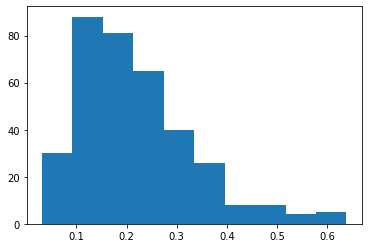

In [82]:
microevals = create_rogue_eval_files("../data/predictions/unitTesting_save", "../data/predictions/unitTesting", False)
plt.hist(microevals)
plt.show()

In [61]:
import os
import pandas as pd
import numpy as np
from ast import literal_eval
import matplotlib.pyplot as plt

In [11]:
from rouge_score import rouge_scorer

In [12]:
scorer = rouge_scorer.RougeScorer(['rouge1', 'rougeL'], use_stemmer=True)
scores = scorer.score('The quick brown fox jumps over the lazy dog',
                      'The quick brown dog jumps on the log.')

In [13]:
scores["rougeL"].fmeasure

0.5882352941176471

In [55]:
def score_ans(preds, answ1, answ2, max_over_preds=False):
    preds = literal_eval(preds)
    pred = str(preds).replace("[CLS]", "").replace("[SEP]", "").replace("#", "")
    if max_over_preds:
        best = 0
        for pred in preds:
            scorer = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)
            scores1 = scorer.score(answ1, pred)
            scores2 = scorer.score(answ2, pred)
            score = max(scores1["rougeL"].fmeasure, scores2["rougeL"].fmeasure)
            if score > best:
                best = score
        return best
    else:
        pred = preds[0]
        for i in range(len(preds)):
            if len(pred) > 3 and len(pred) < 100:
                pred = preds[i]
                break
        scorer = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)
        scores1 = scorer.score(str(answ1), str(pred))
        scores2 = scorer.score(str(answ2), str(pred))
        score = max(scores1["rougeL"].fmeasure, scores2["rougeL"].fmeasure)
        return score
        
    

In [15]:
score_ans('The quick brown fox jumps over the lazy dog', 'The quick brown dog jumps on the log.', 'log.')

0.5882352941176471